### Introduction to Machine Learning in Finance and Insurance (Spring 2024)
# Project 2: Insurance Claim Prediction

### Team members: LastName1 FirstName1, LastName2 FirstName2, LastName3 FirstName3

In [1]:
### Import all the Python libraries you are going to use
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [2]:
### Fix random seed for reproducibility
sed_val = 10
np.random.seed(sed_val)

# Exercise 1. Poisson GLM.

In [3]:
# Read csv file
# You can use pandas (see the notebook "Project 2 - Insurance Claim Prediction - Sandbox")
mtpl_freq_df = pd.read_csv('freMTPL2freq.csv',
                           sep=';',
                           decimal=',')

In [4]:
mtpl_freq_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678007 entries, 0 to 678006
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   VehPower    678007 non-null  int64  
 1   VehAge      678007 non-null  int64  
 2   DrivAge     678007 non-null  int64  
 3   BonusMalus  678007 non-null  int64  
 4   VehBrand    678007 non-null  object 
 5   VehGas      678007 non-null  object 
 6   Density     678007 non-null  int64  
 7   Region      678007 non-null  object 
 8   Exposure    678007 non-null  float64
 9   ClaimNb     678007 non-null  int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 51.7+ MB


* there are 5 numerical features and 3 categorical features

In [5]:
# Check that exposure is always positive
all(mtpl_freq_df.Exposure > 0)

True

In [6]:
# Add frequency to the data
mtpl_freq_df['Freq'] = mtpl_freq_df.ClaimNb / mtpl_freq_df.Exposure
mtpl_num_features = mtpl_freq_df.describe().columns
mtpl_freq_df.describe()

,VehPower,VehAge,DrivAge,BonusMalus,Density,Exposure,ClaimNb,Freq
count,678007.000000,678007.000000,678007.000000,678007.000000,678007.000000,678007.000000,678007.000000,678007.000000
mean,6.454653,7.044218,45.499061,59.761588,1792.430975,0.528547,0.038913,0.117907
std,2.050902,5.666235,14.137492,15.636700,3958.663031,0.364081,0.204752,2.002881
min,4.000000,0.000000,18.000000,50.000000,1.000000,0.002732,0.000000,0.000000
25%,5.000000,2.000000,34.000000,50.000000,92.000000,0.180000,0.000000,0.000000
50%,6.000000,6.000000,44.000000,50.000000,393.000000,0.490000,0.000000,0.000000
75%,7.000000,11.000000,55.000000,64.000000,1658.000000,0.990000,0.000000,0.000000
max,15.000000,100.000000,100.000000,230.000000,27000.000000,1.000000,5.000000,365.000000


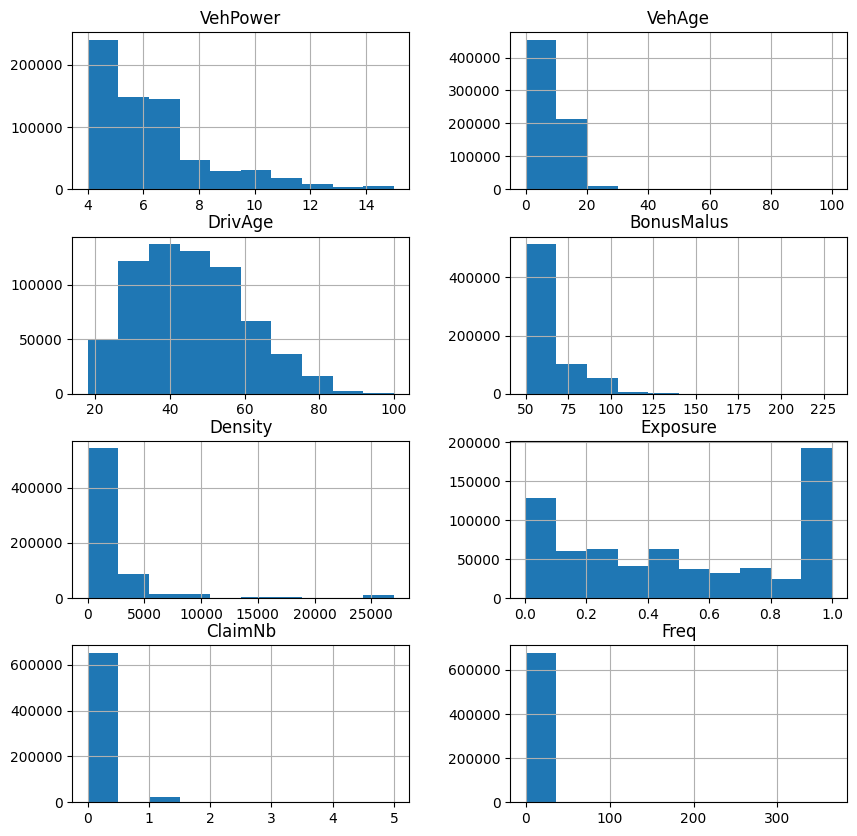

In [7]:
# Lets have a look at the distributions of the numerical features
mtpl_base_feautures, mtpl_response = mtpl_freq_df.columns[:-3], mtpl_freq_df.columns[-3:]
mtpl_freq_df.hist(layout=(4,2), figsize=(10,10))
plt.show()

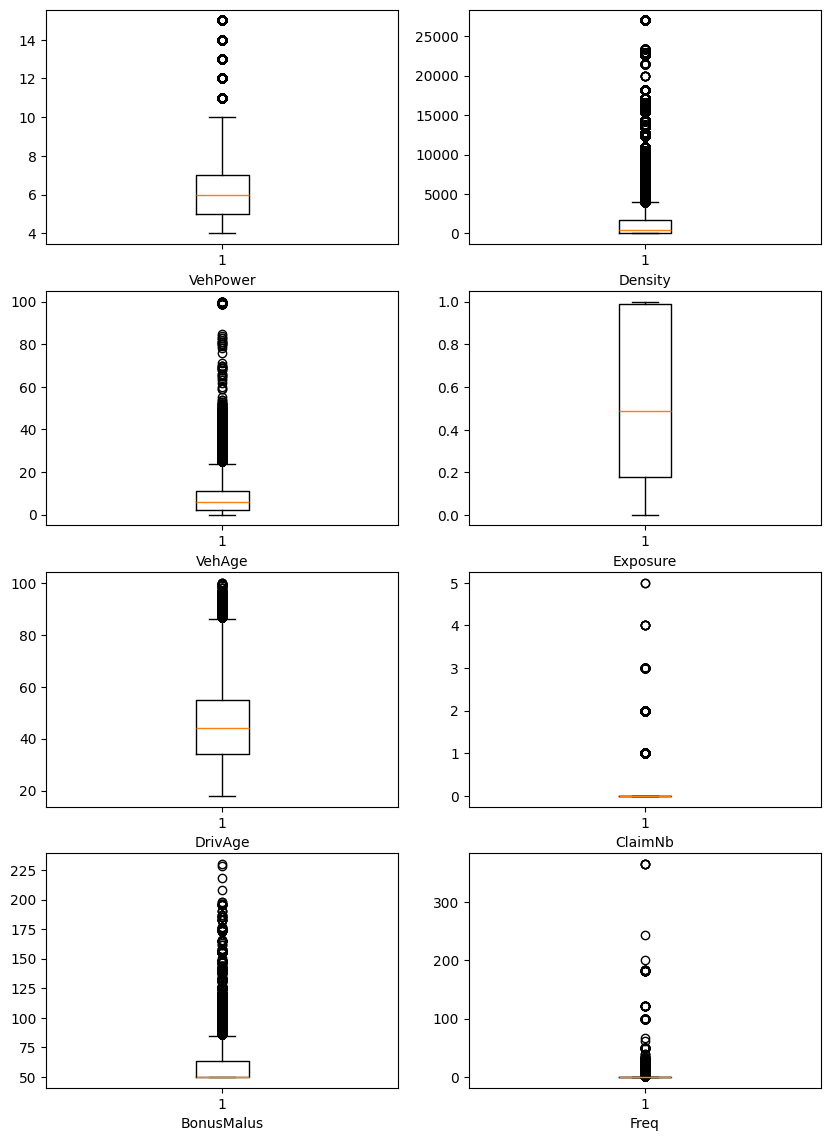

In [8]:
fig, axs = plt.subplots(4, 2, figsize=(10, 14))
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i,j].boxplot(mtpl_num_features[(i)+j*axs.shape[0]],data=mtpl_freq_df)
        axs[i,j].set_xlabel(mtpl_num_features[(i)+j*axs.shape[0]])
plt.show()

Many features are skewed and we could benefit from preprocessing

In [9]:
# Add extra engineered features to the dataset
mtpl_freq_df['DrivAge2'] = np.power(mtpl_freq_df['DrivAge'],2)
mtpl_freq_df['BonusM_DriveAge'] = mtpl_freq_df['BonusMalus'] * mtpl_freq_df['DrivAge']
mtpl_freq_df['BonusM_DrivAge2'] = mtpl_freq_df['BonusMalus'] * mtpl_freq_df['DrivAge2']

mtpl_engineered_feautures = ['DrivAge2', 'BonusM_DriveAge', 'BonusM_DrivAge2']
mtpl_features = mtpl_base_feautures.tolist() + mtpl_engineered_feautures


### Test train split

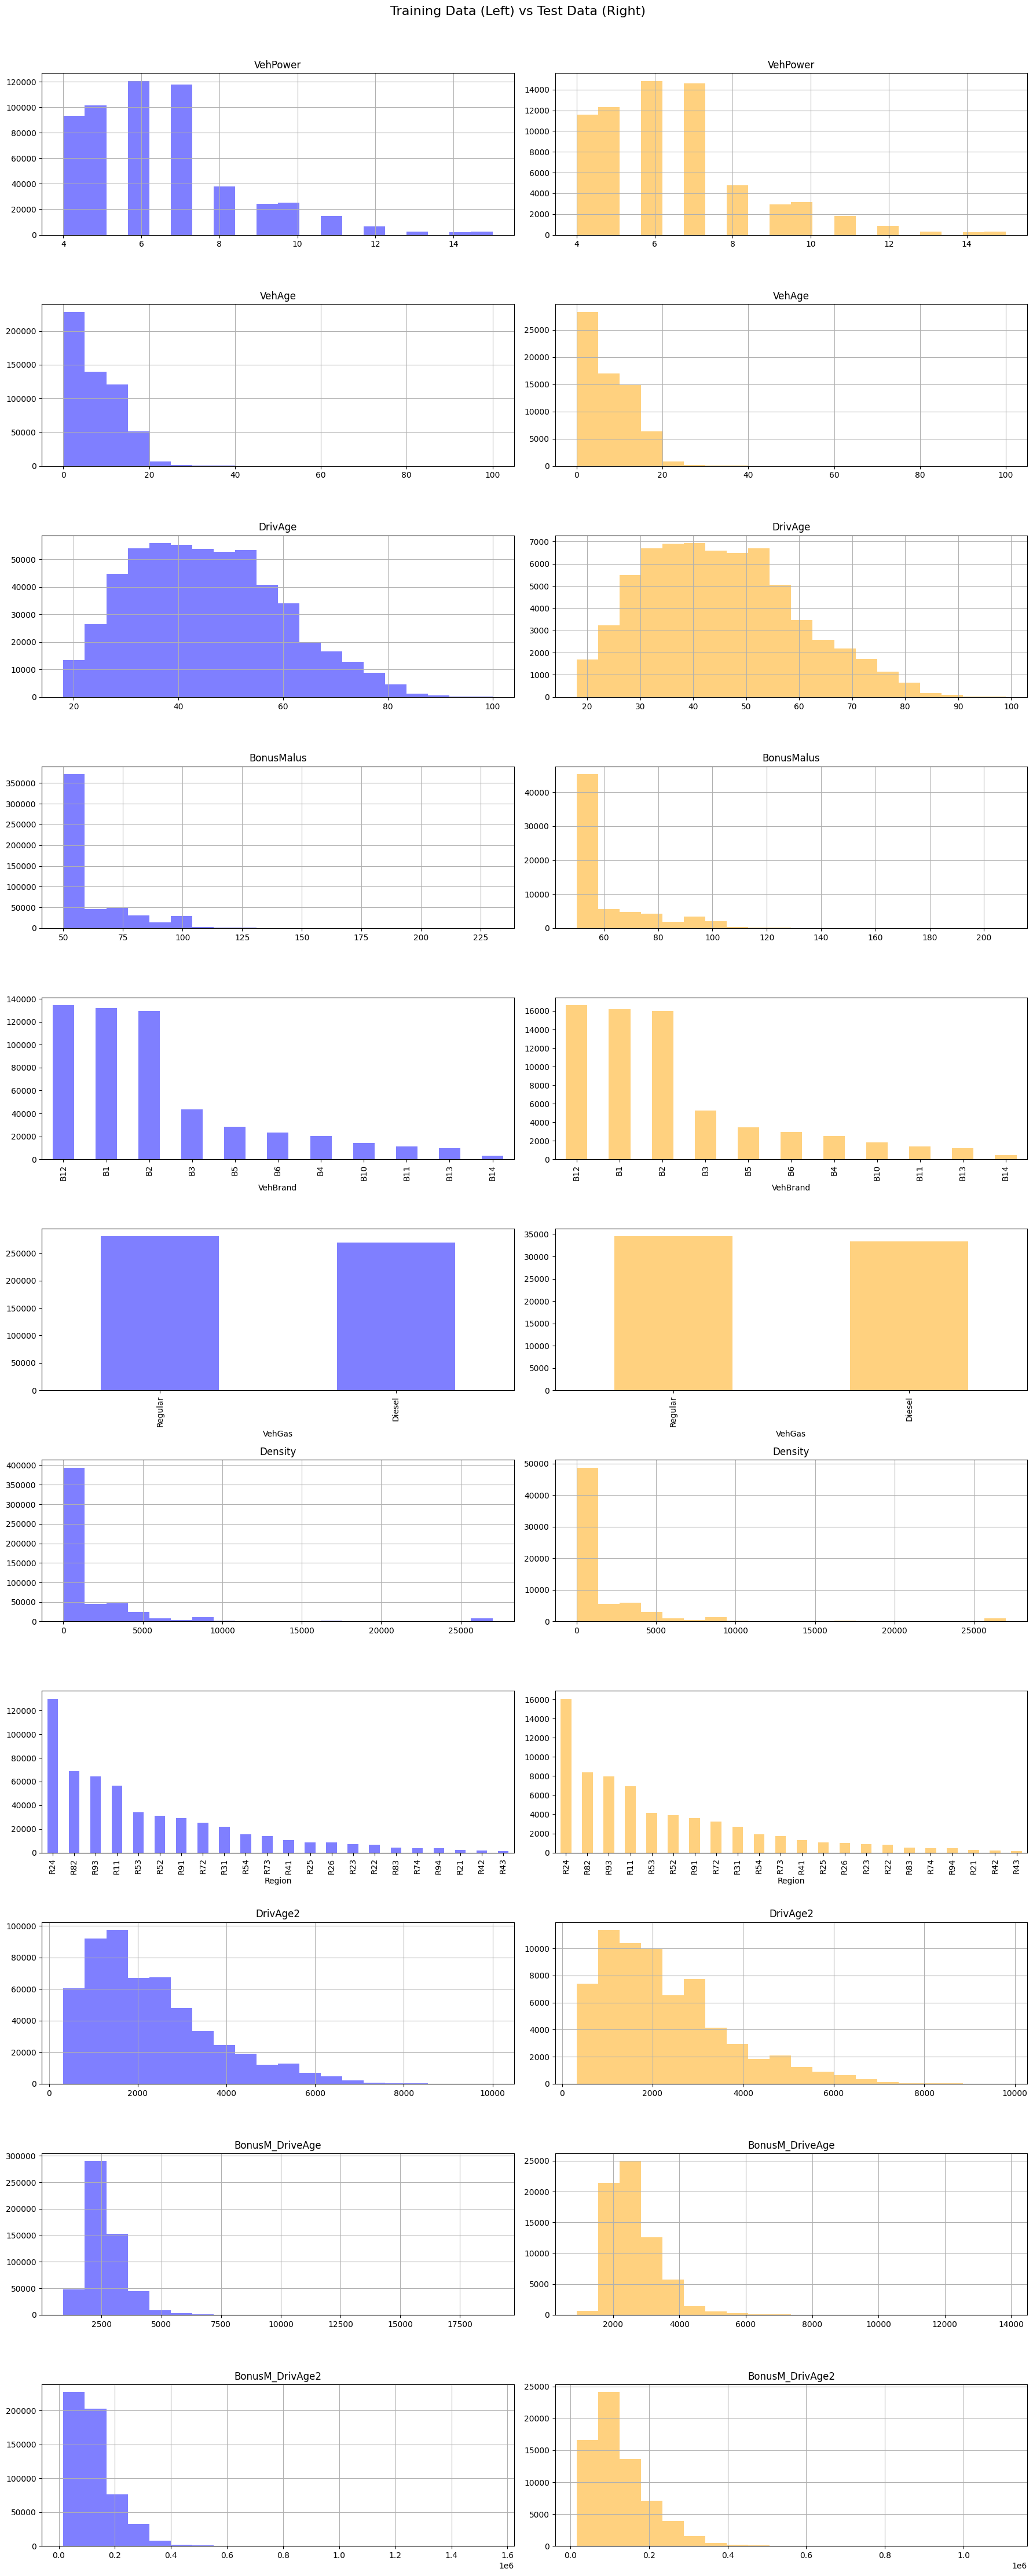

In [10]:
from sklearn.model_selection import train_test_split

X = mtpl_freq_df[mtpl_features]
y = mtpl_freq_df[mtpl_response]

num_features = sorted(X.describe().columns.tolist())

# Train, validation and test data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=sed_val)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=sed_val)

# Compare daata before and after the split
num_plots = len(mtpl_features)
fig, axs = plt.subplots(nrows=num_plots, ncols=2, figsize=(18,num_plots*4))

for idx, feature in enumerate(mtpl_features):
        if X_train[feature].dtype == 'object':
            X_train[feature].value_counts().plot(kind='bar', color='blue', ax=axs[idx, 0], alpha=0.5)
            X_test[feature].value_counts().plot(kind='bar', color='orange', ax=axs[idx, 1], alpha=0.5)
        else:
            X_train.hist(feature, bins=20, alpha=0.5, label='Training Set', color='blue', ax=axs[idx, 0])
            X_test.hist(feature, bins=20, alpha=0.5, label='Test Set', color='orange', ax=axs[idx, 1])


plt.suptitle("Training Data (Left) vs Test Data (Right)", fontsize=16, y=1.01)
plt.subplots_adjust(top=0.2) 
plt.tight_layout()

plt.show()

Visually the distributions of train and test data looks similar

### Preprocessing pipeline

In [11]:
from sklearn.base import TransformerMixin
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from matplotlib.ticker import FuncFormatter, MaxNLocator

class CustomBinner(TransformerMixin):
    def __init__(self, bins, labels):
        self.bins = bins
        self.labels = labels

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = pd.cut(X.iloc[:, 0], bins=self.bins, labels=self.labels)
        return X.values.reshape(-1, 1)
    
    def get_feature_names_out(self, input_features=None):
        # Return input feature names unchanged
        return input_features

#### Log transformation and binning 

In [57]:
# Pre-process features
def create_transformer(num_features, bin_features, one_hot_features, engineered_feauters):
        def gen_transformer(kind: str = 'full'):#, num_features=num_features, bin_features=bin_features, one_hot_features=one_hot_features, engineered_feauters=engineered_feauters):
                """returns transformer dependend on the usecase

                Args:
                kind (str): test - only log transform and normalise,
                            base - log transform, normalise and one-hot encodeing
                                        but without engineered features
                            full - all features included
                            nn - one_hot encoding of categorical features
                """
                bins = [-np.inf, 5, 12, np.inf]
                labels = ['car_0_6', 'car_6_13', 'car_13+']
                local_num_features = num_features
                
                bin_transformer = make_pipeline(CustomBinner(bins, labels))
                
                log_transformer = make_pipeline(FunctionTransformer(np.log, validate=True),
                                                StandardScaler())
                if kind == 'nn' or kind == 'nn_glm':
                        one_hot_transformer_GLM = make_pipeline(OneHotEncoder(handle_unknown='ignore'))
                else:
                        one_hot_transformer_GLM = make_pipeline(OneHotEncoder(handle_unknown='ignore', drop='first'))


                if kind != 'full':
                        local_num_features = sorted(list(set(local_num_features)
                                            - set(engineered_feauters)))
                
                # Remove features that will be turned into categorical variable
                if kind != 'nn':
                        local_num_features = sorted(list(set(local_num_features)
                                                - set(bin_features)))
                
                if kind == 'test':
                        preprocessor = make_column_transformer(
                                (log_transformer, local_num_features),
                                (bin_transformer, bin_features),
                                remainder='drop'
                        )
                        columns = local_num_features + bin_features
                elif kind == 'nn':
                        preprocessor = make_column_transformer(
                                ('passthrough', local_num_features),
                                (one_hot_transformer_GLM, one_hot_features),
                                remainder='drop'
                        )
                        columns = local_num_features + one_hot_features
                elif kind == 'nn_glm':
                        preprocessor = make_column_transformer(
                                (log_transformer, local_num_features),
                                ('passthrough',bin_features),
                                (one_hot_transformer_GLM, one_hot_features),
                                remainder='drop')
                        columns = local_num_features + one_hot_features                        
                else:   
                        bin_transformer = make_pipeline(
                                        *bin_transformer,
                                        one_hot_transformer_GLM)
                        
                        preprocessor = make_column_transformer(
                                (log_transformer, local_num_features),
                                (bin_transformer, bin_features),
                                (one_hot_transformer_GLM, one_hot_features),
                                remainder='drop'
                        )
                        columns = local_num_features + bin_features + one_hot_features

                print(f'preprocessor version: {kind}\ntransforming features: {sorted(columns)}')
                return preprocessor, columns
        return gen_transformer

one_hot_features = mtpl_freq_df.select_dtypes(include=['object']).columns.tolist()
bin_features = ['VehAge']

preproc = create_transformer(num_features,
                             bin_features,
                             one_hot_features,
                             mtpl_engineered_feautures)

#### Impact of feature transformations

In [13]:
preprocessor, columns = preproc('test')
X_train_log_bin = pd.DataFrame(preprocessor.fit_transform(X_train), columns=columns)
X_train_log_bin = X_train_log_bin.convert_dtypes(infer_objects=True)

preprocessor version: test
transforming features: ['BonusMalus', 'Density', 'DrivAge', 'VehAge', 'VehPower']


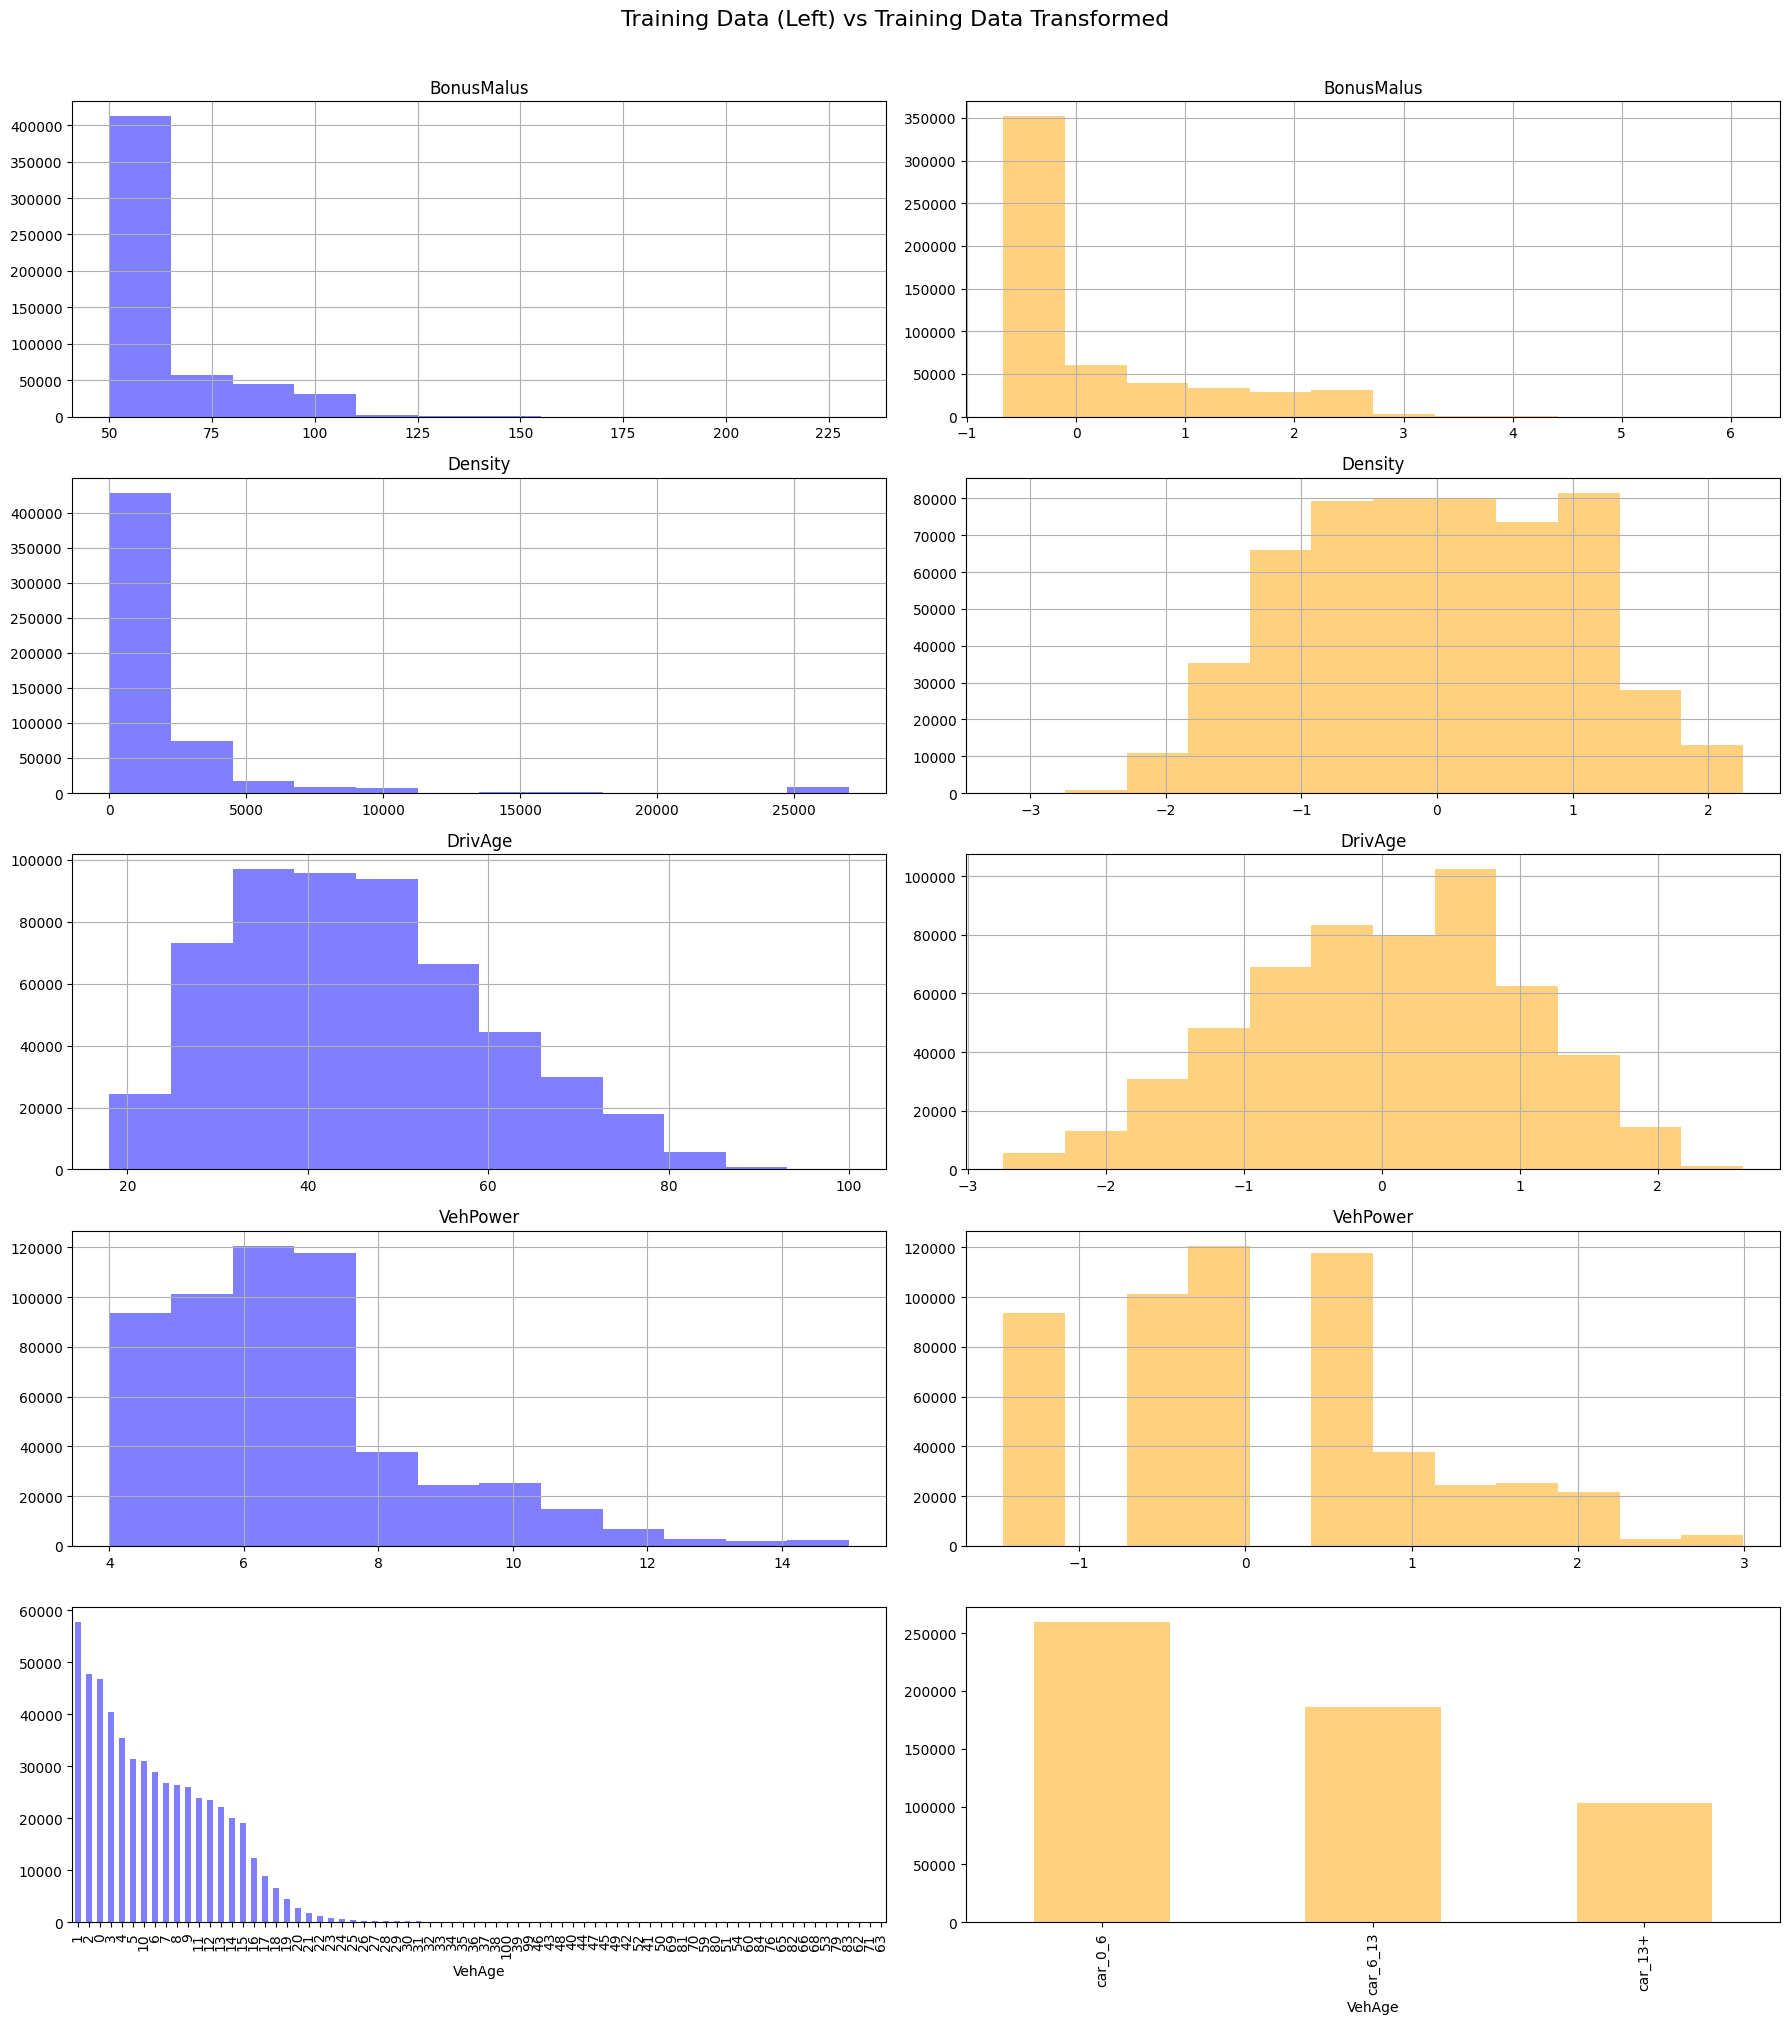

In [14]:
# Define a custom formatter function to format ticks
def format_ticks(value, _):
    return '{:.1f}'.format(value)  # Formats to 2 decimal points

num_plots = len(columns)
fig, axs = plt.subplots(nrows=num_plots, ncols=2, figsize=(18,num_plots*4))

for idx, feature in enumerate(columns):
        if X_train_log_bin[feature].dtype == 'string':
            X_train[feature].value_counts().plot(kind='bar', color='blue', ax=axs[idx, 0], alpha=0.5)
            X_train_log_bin[feature].value_counts().plot(kind='bar', color='orange', ax=axs[idx, 1], alpha=0.5)
        else:
            X_train.hist(feature, alpha=0.5, color='blue', ax=axs[idx, 0], bins=12)
            X_train_log_bin.hist(feature, alpha=0.5, color='orange', ax=axs[idx, 1], bins=12)

plt.suptitle("Training Data (Left) vs Training Data Transformed", fontsize=16, y=1.01)
plt.subplots_adjust(top=0.2) 
plt.tight_layout()

plt.show()

In [15]:
from sklearn.dummy import DummyRegressor

preprocessor_base, columns = preproc('base')
preprocessor_full, coluns_full = preproc('full')

dummy = Pipeline([
    ('preproc', preprocessor_base),
    ('regressor', DummyRegressor(strategy='mean'))
]).fit(X_train, y_train['Freq'], regressor__sample_weight=y_train["Exposure"])

preprocessor version: base
transforming features: ['BonusMalus', 'Density', 'DrivAge', 'Region', 'VehAge', 'VehBrand', 'VehGas', 'VehPower']
preprocessor version: full
transforming features: ['BonusM_DrivAge2', 'BonusM_DriveAge', 'BonusMalus', 'Density', 'DrivAge', 'DrivAge2', 'Region', 'VehAge', 'VehBrand', 'VehGas', 'VehPower']


In [16]:
from sklearn.linear_model import PoissonRegressor

poi_glm_base = Pipeline([
    ('preproc', preprocessor_base),
    ('regressor', PoissonRegressor(alpha=0))
]).fit(X_train, y_train['Freq'], regressor__sample_weight=y_train["Exposure"])

poi_glm_full = Pipeline([
    ('preproc', preprocessor_full),
    ('regressor', PoissonRegressor(alpha=0))
]).fit(X_train, y_train['Freq'], regressor__sample_weight=y_train["Exposure"])


In [17]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_poisson_deviance,
    mean_squared_error,
    
)

metrics = [mean_poisson_deviance,
           mean_absolute_error,
           mean_squared_error]

y_pred_test = [dummy.predict(X_test),
               poi_glm_base.predict(X_test),
               poi_glm_full.predict(X_test)]

y_pred_train = [dummy.predict(X_train),
               poi_glm_base.predict(X_train),
               poi_glm_full.predict(X_train)]


metrics_glm_test = {func.__name__ + '_test': [func(y_test['Freq'], y, sample_weight=y_test['Exposure']) for y in y_pred_test]
                    for func in metrics}

metrics_glm_train = {func.__name__+'_train': [func(y_train['Freq'], y, sample_weight=y_train['Exposure']) for y in y_pred_train]
                    for func in metrics }

dict_model_metric_summary = {**{'Model': ['Dummy', 'GLM_Base', 'GLM_Full']},
                                     **metrics_glm_test,
                                     **metrics_glm_train}

model_metric_summary = pd.DataFrame(dict_model_metric_summary)


In [18]:
# Set the display format for decimal places
pd.set_option('display.float_format', lambda x: f'{x:.5f}')
model_metric_summary.sort_values(by='mean_poisson_deviance_test')

,Model,mean_poisson_deviance_test,mean_absolute_error_test,mean_squared_error_test,mean_poisson_deviance_train,mean_absolute_error_train,mean_squared_error_train
1,GLM_Base,0.45059,0.13645,0.22826,0.45832,0.13851,0.23775
2,GLM_Full,0.45062,0.13651,0.22827,0.45831,0.13857,0.23775
0,Dummy,0.47108,0.13898,0.23021,0.47873,0.14088,0.23973


* Because the data is skewed towards 0 claims even dummy model gets fairly good results
* Both base and full glm models improve on the dummy model, with slight advantage of the base model at the selected random seed and train, validation, test data split.

# Exercise 2. Poisson feedforward neural network.

In [19]:
# TODO: Evaluation of the calibration of predictions
# TODO: Evaluation of the ranking power
# TODO: Shap values

In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import BayesianOptimization, RandomSearch
from keras_tuner import Objective
from tensorflow.keras.layers import Dense, BatchNormalization, Input
from keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import json
import pickle
from keras.models import load_model

In [21]:
# Setup
top_models = []
train_models = 0 # 0 - read pretrained models, 1 - go throught training procedure

# Set input layer size
preprocessor_nn, columns_nn = preproc('nn')

# Apply one-hot encoding to the categorical variables
X_train_nn = preprocessor_nn.fit_transform(X_train)
X_test_nn = preprocessor_nn.transform(X_test)
input_layer_size = X_train_nn.shape[1]

X_val_nn = preprocessor_nn.transform(X_val)
y_train_freq = np.array(y_train['Freq'])
y_val_freq = np.array(y_val['Freq'])
val_weights = np.array(y_val['Exposure'])

preprocessor version: nn
transforming features: ['BonusMalus', 'Density', 'DrivAge', 'Region', 'VehAge', 'VehBrand', 'VehGas', 'VehPower']


In [22]:
def save_model_and_history(model: keras.Sequential, directory: str) -> None:
    # Save model and training history

    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save model and learning history
    model.save(f"{directory}/{model.name}.keras")
    with open(f'{directory}/history_{model.name}.pickle', 'wb') as file:
        pickle.dump(model.history.history, file)
    

### Neural networks

##### Keras random search functions

In [29]:
# Random search parameter names
name_kern_regular_layer = 'kernel_regularizer_layer'
name_neuron_count_layer = 'neuron_count_layer'
name_learning_rate = 'learning_rate'
name_activation_function = 'activation_function'
name_elu_param = 'elu_a'
name_num_hidden_layers = 'hidden_layers'

def build_model(hp):
    """
    Build fully connected feed forward neural network models using 
    RandomSearch for some of the parameters.
    """
    model = keras.Sequential()

    # Set network level hp
    hp_activation = hp.Choice(f'{name_activation_function}', ['relu', 'swish', 'elu'])
    hp_learning_rate = hp.Choice(name_learning_rate, values=[0.0005, 0.0025, 0.00001])
    hp_elu_param = hp.Choice(f'{name_elu_param}', values=[0.001, 0.5, 1.0])    
    hp_num_hidden_layers = hp.Int(f'{name_num_hidden_layers}', min_value=3, max_value=13, step=2)

    model.add(Input(shape=X_train_nn.shape[1:]))
  
    for i in range(hp_num_hidden_layers):
        # Set layer hyperparameters
        hp_neuron_count_layer = hp.Int(f'{name_neuron_count_layer}_{i}', min_value=20, max_value=100, step=20)
        hp_kernel_regularizer_layer = hp.Choice(f'{name_kern_regular_layer}_{i}', values=[0.001, 0.1, 0.0])

        # Add network layers, transform and normalise
        model.add(Dense(units=hp_neuron_count_layer, kernel_regularizer=l2(hp_kernel_regularizer_layer)))
        if hp_activation == 'elu':
            model.add(layers.ELU(alpha=hp_elu_param))
        else:
            model.add(layers.Activation(hp_activation))
        
        model.add(BatchNormalization())

    # Output layer
    model.add(Dense(units=1, activation='exponential'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=keras.losses.Poisson(),
                  metrics=['mse', 'mae'])
    return model
    

In [30]:
def search_and_train_randomsearch_nn(num_arch_to_keep):
    """
    Executes a random search for the best hyperparameters using the buld_model function defined above.
    Once finished, it trains a NeuralNetwork with the found hyperparameters and returns it.
    """
    # Initialize RandomSearch on dataset 1
    tuner = BayesianOptimization(
        build_model,
        objective=Objective('loss', 'min'),
        max_trials=35,
        executions_per_trial=1,
        directory='hp_random_search',
        project_name=f'fr_mtpl_frequency'
    )

    # Search for best hyper parameters
    tuner.search(X_train_nn, y_train_freq,epochs=3,
                sample_weight = y_train['Exposure'])

    # Save all hyperparameters
    all_hyperparameters = []

    # Iterate over all trials
    for trial in tuner.oracle.get_best_trials():
        # Retrieve hyperparameters from the trial
        hyperparameters = trial.hyperparameters.values
        all_hyperparameters.append(hyperparameters)

    sampled_hyperparameters_json = json.dumps(all_hyperparameters, indent=4)

    directory = 'tuner_best'
    if not os.path.exists(directory):
    # Create the directory if it doesn't exist
        os.makedirs(directory)

    with open(f'{directory}/sampled_hyperparameters.json', 'w') as json_file:
        json_file.write(sampled_hyperparameters_json)

    # Save best model architectures for a full training
    top_models = tuner.get_best_models(num_models=num_arch_to_keep)
    for idx, model in enumerate(top_models):
        model_json = model.to_json()
        with open(f'{directory}/model_{idx+1}.json', 'w') as json_file:
            json_file.write(model_json)
    
    return tuner

#### Build and train Neural Networks

##### Reference neural network
- Simple architecture
- No fine-tuning

##### Search for the best architecture in the hyperparameter space
- Activation functions: relu, swish, elu
- Elu activation function parameter: 0.001, 0.5, 1
- Learning reate: 0.0005, 0.0025, 0.00001
- Number of hidden layers: Odd number between 3 and 13
- Number of neurons in each hidden layer: Multiple of 20 less than 100
- L2 regularization parameter in each hidden layer: 0.001, 0.1, 0.0

In [31]:
# Build simple nn for reference
directory = 'full_learning'
model_name = 'reference_nn'

# Select number of models to retrain <= 35
num_best_models = 3

if train_models == 1:
    tuner = search_and_train_randomsearch_nn(num_best_models)
###########################################################################
# Train simple reference model
###########################################################################

if train_models == 1:
    ref_nn = keras.Sequential()
    ref_nn.add(Dense(units=80, activation='relu'))
    ref_nn.add(Dense(units=80, activation='relu'))
    ref_nn.add(Dense(units=80, activation='relu'))
    ref_nn.add(Dense(units=80, activation='relu'))
    ref_nn.add(Dense(units=80, activation='relu'))
    ref_nn.add(Dense(units=80, activation='relu'))
    ref_nn.add(Dense(units=1, activation='exponential'))

    ref_nn.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001),
                    loss=keras.losses.Poisson(),
                    metrics=['mse', 'mae'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    ref_nn.fit(x=X_train_nn.toarray(), y=y_train_freq,
                        sample_weight = y_train['Exposure'], 
                        validation_data=(X_val_nn, y_val_freq, val_weights),
                        batch_size=8000,
                        epochs=1000,
                        callbacks=[early_stopping])
    # Get nn predictions
    ref_nn.name = model_name
    save_model_and_history(ref_nn, directory)
else:
    ref_nn = tf.keras.models.load_model(f'{directory}/{model_name}.keras')
top_models.append(ref_nn)

###########################################################################
# Fully train best architectures found during random search
###########################################################################
# Set wd
directory = 'full_learning'

# Load best performing architectures and perform full training
for idx in range(num_best_models):
    model_name = f'model_{idx+1}'
    if train_models == 1:
        with open(f'tuner_best/model_{idx+1}.json', 'r') as json_file:
            loaded_model_json = json_file.read()

        # define callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

        # Reconstruct the model from the JSON string
        loaded_model = tf.keras.models.model_from_json(loaded_model_json)
        print(f"Training Model {idx+1}")
        loaded_model.fit(x=X_train_nn.toarray(), y=y_train_freq,
                        sample_weight = y_train['Exposure'], 
                        validation_data=(X_val_nn, y_val_freq, val_weights),
                        batch_size=1000,
                        epochs=1000,
                        callbacks=[early_stopping])
        loaded_model.name = model_name

        # Save model and learning history
        save_model_and_history(loaded_model, directory)
    else:
        loaded_model = tf.keras.models.load_model(f'{directory}/{model_name}.keras')
    top_models.append(loaded_model)
    loaded_model = None   

Trial 35 Complete [00h 04m 00s]
loss: 0.14247508347034454

Best loss So Far: 0.1384657323360443
Total elapsed time: 01h 38m 47s


c:\Users\tskor\Documents\GitHub\CAS-ML\venv\lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
c:\Users\tskor\Documents\GitHub\CAS-ML\venv\lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 94 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


##### Collect model metrics

In [33]:

y_pred_nn_test = [nn_model.predict(X_test_nn) for nn_model in top_models]
y_pred_nn_train = [nn_model.predict(X_train_nn) for nn_model in top_models]

metrics_nn_test = {func.__name__ + '_test': [func(y_test['Freq'], y, sample_weight=y_test['Exposure']) for y in y_pred_nn_test]
                    for func in metrics}

metrics_nn_train = {func.__name__+'_train': [func(y_train['Freq'], y, sample_weight=y_train['Exposure']) for y in y_pred_nn_train]
                    for func in metrics }

models = {'Model': [model.name for model in top_models]}


dict_nn_metrics = {**models,
                   **metrics_nn_test,
                   **metrics_nn_train}

model_metric_summary = pd.concat([model_metric_summary, pd.DataFrame(dict_nn_metrics)])

2119/2119 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2119/2119 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2119/2119 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2119/2119 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
17163/17163 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step
17163/17163 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step
17163/17163 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step
17163/17163 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step


In [69]:
model_metric_summary = model_metric_summary.sort_values('mean_poisson_deviance_test')
model_metric_summary

,Model,mean_poisson_deviance_test,mean_absolute_error_test,mean_squared_error_test,mean_poisson_deviance_train,mean_absolute_error_train,mean_squared_error_train
3,model_3,0.44801,0.13317,0.22808,0.45538,0.13527,0.23752
2,model_2,0.44885,0.13865,0.22813,0.45669,0.14072,0.23760
1,model_1,0.44900,0.13833,0.22810,0.45735,0.14043,0.23771
1,GLM_Base,0.45059,0.13645,0.22826,0.45832,0.13851,0.23775
2,GLM_Full,0.45062,0.13651,0.22827,0.45831,0.13857,0.23775
0,reference_nn,0.45269,0.13679,0.22840,0.45948,0.13887,0.23786
0,Dummy,0.47108,0.13898,0.23021,0.47873,0.14088,0.23973


In [93]:
top_models[3].summary()

Model: "model_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 80)             │         3,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 80)             │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         1,620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20)             │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 20)             │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │         2,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 80)             │         8,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 80)             │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 133,445 (521.27 KB)

 Trainable params: 44,041 (172.04 KB)

 Non-trainable params: 1,320 (5.16 KB)

 Optimizer params: 88,084 (344.08 KB)

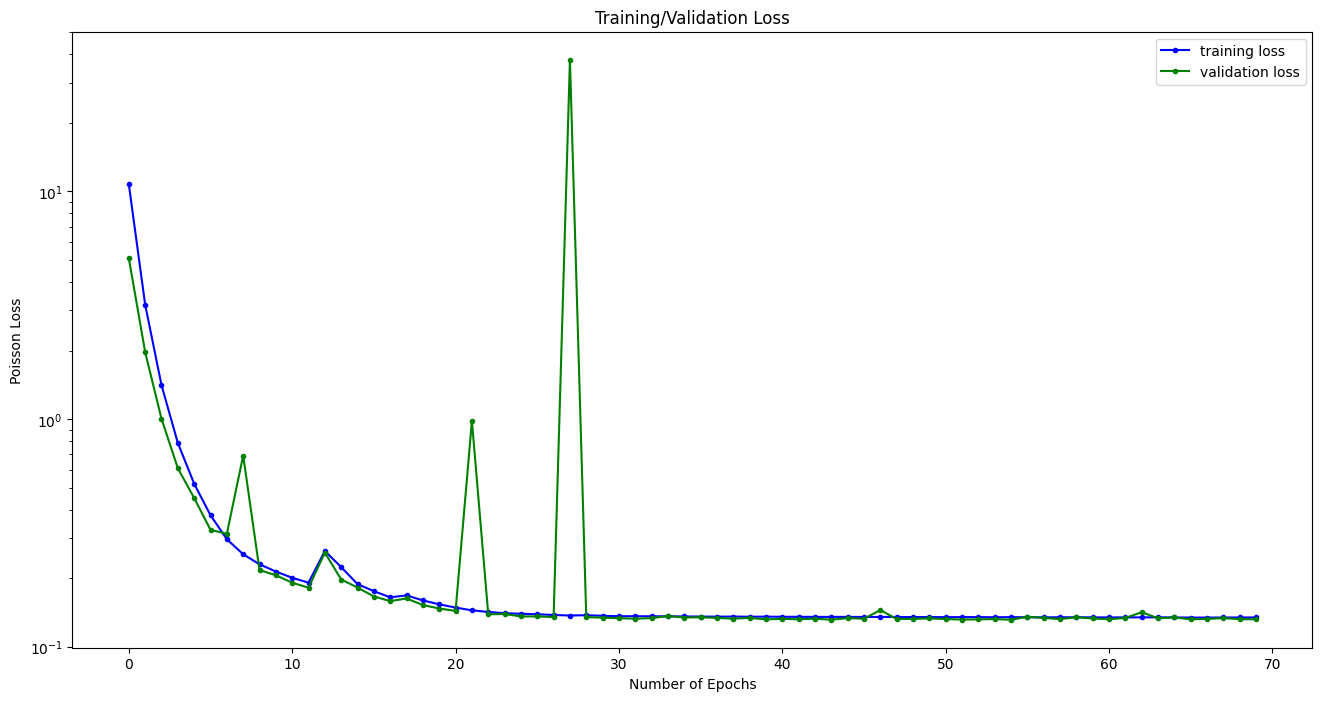

In [81]:

# Assuming hp_nn is the result of training the Keras model
# Example:
# hp_nn = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val))

fig = plt.figure(figsize=(16, 8))  # Set figure size directly in figure creation

# Access training history directly from the History object
history = pd.read_pickle(f'full_learning/history_{top_models[3].name}.pickle')
loss_history = history['loss']
val_loss_history = history['val_loss']
# Plot training loss over epochs
plt.plot(loss_history, 'b.-', label='training loss')
plt.plot(val_loss_history, 'g.-', label ='validation loss' )
plt.title('Training/Validation Loss')
plt.yscale('log')
plt.ylabel('Poisson Loss')
plt.xlabel('Number of Epochs')
plt.legend()

plt.show()

In [ ]:
y_test['Exposure'].shape

(67801,)

In [101]:
pred_claim_n = []
residuals = []
for idx ,_ in enumerate(top_models):
    pred_claim_n.append(y_pred_nn_test[idx].reshape(-1) * y_test['Exposure'])
    residuals.append(abs(pred_claim_n[idx] - y_test['ClaimNb']))
pred_glm_claim_n = y_pred_test[1] * y_test['Exposure']
glm_res = abs(pred_glm_claim_n - y_test['ClaimNb'])

In [102]:
dummy_claim_count = y_pred_test[0] * y_test['Exposure']
dumm_res = abs(dummy_claim_count - y_test['ClaimNb'])
dummy_claim_count.sum()

2643.136212428528

In [96]:
pred_glm_claim_n.sum()

2635.408753577563

In [118]:
list(pred_glm_claim_n)

[0.07789352006896634,
 0.004302027851852947,
 0.025420709215474194,
 0.08186072412158686,
 0.040759842672473505,
 0.04303600540910729,
 0.08108087469026605,
 0.07514778108019446,
 0.013759201957774442,
 0.04658448769441388,
 0.10140014408039454,
 0.10522872281045798,
 0.047704090096093686,
 0.04425619940154521,
 0.05181890616784566,
 0.06699646858670304,
 0.05066661821308573,
 0.039510911312034526,
 0.04166685307735159,
 0.038834923102918355,
 0.013001551956500476,
 0.031298913349437234,
 0.0014958978327392473,
 0.007008967650189624,
 0.0006525015755689374,
 0.09116805913796927,
 0.030300337058857322,
 0.03500140123924763,
 0.013781038335000304,
 0.06867923691814971,
 0.0767057327216471,
 0.13803328479546242,
 0.03724728360413255,
 0.014706534004093995,
 0.037366516390851326,
 0.046312912384088176,
 0.03589632861457876,
 0.1055983153430425,
 0.01668008440347726,
 0.0660293818648048,
 0.023409527513865592,
 0.08443163619739183,
 0.05583699348494998,
 0.01904587373093558,
 0.048774149682

In [123]:

df_claim_nb = pd.DataFrame({'model':'Truth','ClaimN':y_test['ClaimNb'], 'Residual':[0]*len(y_test)})
for idx , model in enumerate(top_models):
    df_claim_nb.loc[len(df_claim_nb):len(df_claim_nb)+len(y_test)] = {'model':[model.name]*len(y_test), 'ClaimN':pred_claim_n[idx], 'Residual':residuals[idx]}

df_claim_nb.loc[len(df_claim_nb)] = {'model':'GLM','ClaimN':list(pred_glm_claim_n), 'Residual':list(glm_res)}


KeyError: 67801

In [120]:
df_claim_nb

,model,ClaimN,Residual
471132,Truth,0,0
229899,Truth,0,0
39844,Truth,0,0
346789,Truth,0,0
19921,Truth,0,0
...,...,...,...
305400,Truth,0,0
199493,Truth,0,0
67801,"[reference_nn, reference_nn, reference_nn, ref...","[0.061823549866676326, 0.006093910932540894, 0...","[0.061823549866676326, 0.006093910932540894, 0..."
67802,"[model_1, model_1, model_1, model_1, model_1, ...","[0.07231495603919029, 0.0051612043380737304, 0...","[0.07231495603919029, 0.0051612043380737304, 0..."


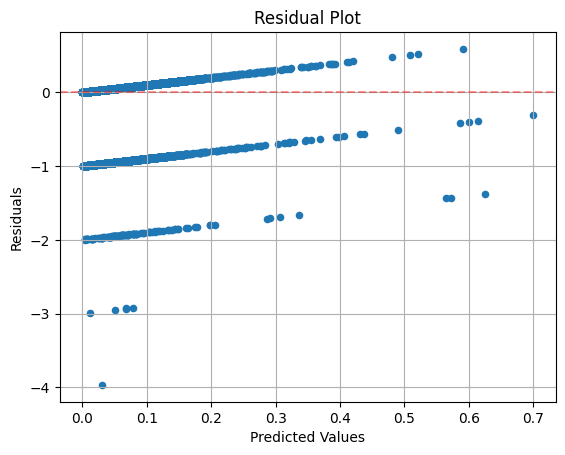

In [240]:
df_claim_nb.plot(kind='scatter',
                 x='best_model_1',
                 y='best_model_res1')
plt.axhline(y=0, color='red', linestyle='--', alpha=.4)  # Add horizontal line at y=0
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

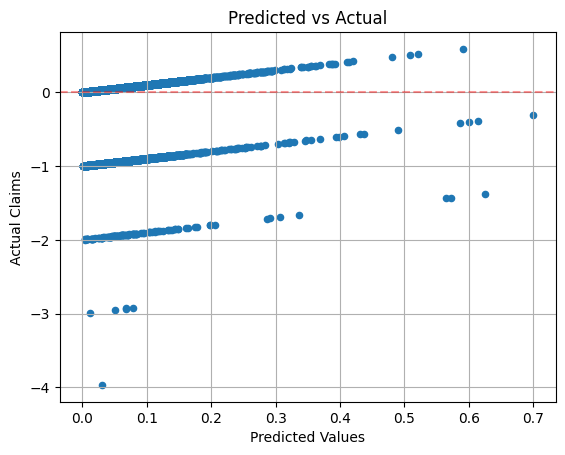

In [241]:
df_claim_nb.plot(kind='scatter',
                 x='best_model_1',
                 y='best_model_res1')
plt.axhline(y=0, color='red', linestyle='--', alpha=.4)  # Add horizontal line at y=0
plt.xlabel('Predicted Values')
plt.ylabel('Actual Claims')
plt.title('Predicted vs Actual')
plt.grid(True)
plt.show()

In [253]:
df_claim_nb.sum()

Actual_ClaimN      2567.000000
best_model_0       2609.434632
best_model_res0    4826.255092
best_model_1       2565.512000
best_model_res1    4816.908260
best_model_2       2445.772701
best_model_res2    4728.899534
best_model_3       2587.188969
best_model_res3    4818.165791
best_model_4       2714.992146
best_model_res4    4991.559731
glm                2635.408754
glm_res            4871.674206
dtype: float64

In [57]:
2643.136212428528 - 2567.000000

76.13621242852787

In [63]:
y_test['ClaimNb'].sum()

2567

In [71]:
pred_glm_claim_n.sum() - y_test['ClaimNb'].sum()

71.31434010952717

In [ ]:
# Save model architecture to JSON file
freq_nn_model_json = freq_nn_model.to_json()
with open("fr_mtpl_freq_model_architecture.json", "w") as json_file:
    json_file.write(freq_nn_model_json)

In [ ]:
# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='gray', linestyle='--')  # Add horizontal line at y=0
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

In [35]:

# Load the Keras model from the file
model = load_model('full_learning/model_3.keras')
best_nn_pred_test = model.predict(X_test_nn)
best_nn_pred_train = model.predict(X_train_nn)

2119/2119 ━━━━━━━━━━━━━━━━━━━━ 2s 976us/step
17163/17163 ━━━━━━━━━━━━━━━━━━━━ 16s 909us/step


In [37]:
model.loss(y_train['Freq'],best_nn_pred_train)

<tf.Tensor: shape=(), dtype=float32, numpy=1.3541826>

In [38]:
print(mean_poisson_deviance(y_test['Freq'], best_nn_pred_test, sample_weight=y_test['Exposure']),
mean_poisson_deviance(y_train['Freq'], best_nn_pred_train, sample_weight=y_train['Exposure']), sep="\n")

ValueError: Mean Tweedie deviance error with power=1 can only be used on non-negative y and strictly positive y_pred.

0.44998615599818514
0.4548377200765802

In [186]:
mean_poisson_deviance(y_test['Freq'], best_nn_pred_test, sample_weight=y_test['Exposure'])

0.5195810359435404